In [33]:
import pandas as pd
import sys
#setting pyensembl cache dir 
import os 
import pyensembl as pe
import pybedtools

os.environ['PYENSEMBL_CACHE_DIR'] = '/data/backup/xiavan/pyensembl/cache'
from wrenlab import ensembl as we
from wrenlab.ncbi import gene
from wrenlab import enrichment
from wrenlab.matrix.mmat import MMAT
from wrenlab.normalize import quantile

from sklearn.linear_model import LogisticRegression as LogR
from sklearn.decomposition import PCA 
import metalearn
from multiprocessing import Pool
from sklearn.metrics import roc_auc_score

import sklearn
import wrenlab
import io

In [2]:
path = "/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/gdc/"
os.listdir(path)

['gdc_450k.h5', 'gdc_expression.h5', 'gdc_meta.h5', 'gdc_meta.csv']

In [3]:
me = path+"gdc_450k.h5"
me = pd.read_hdf(me,key="data")
me.shape

(396065, 780)

In [4]:
ex = path+"gdc_expression.h5"
ex = pd.read_hdf(ex,key="data")
ex.shape

(59016, 868)

In [5]:
me

file_id,0024adf5-ef9d-4711-bfab-8cf5c39b8a89,00a2364d-7385-4fa8-8562-b4f19548505a,00e6c633-7b4d-4c88-96f0-14b3f63670d7,00e912ed-409a-4341-9c82-47ba4214164c,00ff6010-65c6-4738-8b92-31e5f34b88d1,0128f827-06f6-44a2-a819-c93929b5b6d2,019ad531-bde6-4ca2-bdfd-0dcd5f5d50ee,01b0e614-4561-43ee-9f6a-d8ccadde57d1,01cbf0ea-4b4b-4d35-90e0-523a8930b91f,025a71ff-361e-4b76-bad3-cceb525b0a7e,...,faf1ec57-1724-427b-9d10-d69b5603db39,fb37a02a-1032-49ec-ad3f-1331bbb95184,fbc15cc8-bc1f-4b98-b952-f446ddca7d30,fc5a8954-7e2a-42e8-906b-93d3d4e5ebb7,fe538ecd-e50b-489e-8f04-0279da73bc61,febdeec0-c670-46d4-9c93-6cfba5a5e8b0,fec99d9c-e8d3-4ac3-8b38-d8d2f8b8d988,fed18421-9881-4765-b57e-817f071bb44a,ff7f3b65-55e0-4bdb-9f82-c31c6146f6d2,ffb7fd0c-ed19-4968-9679-a8406f357c81
0,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.296965,0.207822,0.172922,0.497237,0.306946,0.465502,0.128762,0.245344,0.257469,0.246532,...,0.548364,0.232464,0.616396,0.340358,0.153775,0.140246,0.324533,0.736862,0.112541,0.541081
cg00000165,0.217459,0.239452,0.536158,0.205091,0.146007,0.191952,0.346639,0.271008,0.799054,0.167761,...,0.221722,0.215673,0.229489,0.248085,0.282402,0.366732,0.115519,0.181596,0.379661,0.287679
cg00000236,0.837925,0.855045,0.868116,0.859443,0.706442,0.848392,0.908773,0.867830,0.900856,0.790035,...,0.842712,0.814596,0.835077,0.829289,0.902880,0.859874,0.855823,0.836236,0.873848,0.871635
cg00000289,0.672824,0.691211,0.631033,0.757576,0.389458,0.755973,0.661899,0.761881,0.763431,0.660676,...,0.701686,0.682105,0.751824,0.680232,0.748922,0.768896,0.741239,0.732323,0.583192,0.649968
cg00000292,0.649083,0.629057,0.326462,0.492850,0.827887,0.516962,0.675714,0.687586,0.550264,0.767287,...,0.486710,0.649626,0.518271,0.672614,0.723624,0.660613,0.679059,0.793604,0.815626,0.642983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs9363764,0.539558,0.943700,0.893732,0.565897,0.061310,0.567781,0.203019,0.934118,0.051500,0.073241,...,0.934109,0.572867,0.546583,0.924600,0.599509,0.581122,0.521923,0.469330,0.554141,0.903811
rs939290,0.938532,0.535848,0.548170,0.531749,0.529938,0.034971,0.819110,0.944689,0.045453,0.940326,...,0.943224,0.049307,0.535542,0.577500,0.038994,0.040036,0.933351,0.931495,0.938534,0.939622
rs951295,0.064156,0.550311,0.236745,0.937603,0.949965,0.063195,0.953412,0.944465,0.687640,0.516565,...,0.057812,0.051152,0.052057,0.563479,0.555539,0.957215,0.519119,0.066427,0.566964,0.039036


In [6]:
corr = "/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/091020_run/paired_correlations/gdc_paired_correlations.h5"
corr = pd.read_hdf(corr,key="data")
corr.columns = [x.split("_")[0] for x in corr.columns]
corr.shape

(59011, 301001)

In [7]:
p = "/data/ncbi.bak/geo/GPL13534/meta/meth_tools/9606_feature_cpgs.csv"
p = pd.read_csv(p,index_col=0)
p.head()

,introns,regels,simple_repeats,exons,genes,islands,repeats,shelves,microsats,shores,promoters,simple_repeats_near,oreganno,dnase
cg00089915,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
cg00920348,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
cg02994349,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
cg13052034,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
cg17162576,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


In [11]:
A = "/home/xiavan/gitlab/mana/go_genes.csv"
A = pd.read_csv(A,sep=",",header=0,index_col=0)
A.head()

,43312,2576,48863,7597,10951,1869,51056,22617,6805,19216,...,106040,2760,32711,39531,32597,32913,32600,51494,90133,1900101
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51209,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79888,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55313,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
gb_yh = pd.read_hdf("/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/mana_gb_predicted_go_bool.h5",key="data")
tss_yh = pd.read_hdf("/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/mana_tss1500_predicted_go_bool.h5",key="data")
gb_yh,gb_y = gb.align(A,axis=None,join="inner")
tss_yh,tss_y = tss.align(A,axis=None,join="inner")
print(gb_y.shape,gb_yh.shape)
print(tss_y.shape,tss_yh.shape)

(16467, 12323) (16467, 12323)
(13399, 12323) (13399, 12323)


In [83]:
percent_match = (gb_y == gb_yh)
percent_match = percent_match.sum(axis=1)/percent_match.shape[1]

In [142]:
pmt = (tss_y == tss_yh)
pmt = pmt.sum(axis=1)/pmt.shape[1]

In [238]:
tss200_yh = pd.read_hdf("/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/mana_tss200_predicted_go_bool.h5",key="data")
tss200_yh,tss200_y = tss200_yh.align(A,axis=None,join="inner")
pmtss200 = (tss200_y == tss200_yh)
pmtss200 = pmtss200.sum(axis=1)/pmtss200.shape[1]
pmtss200

2            0.937191
9            0.964376
10           0.956910
12           0.947415
15           0.929319
               ...   
109617006    0.915118
110117498    0.963808
112267871    0.971760
112441434    0.845898
118142757    0.958127
Length: 9196, dtype: float64

In [82]:
gb_y

,43312,2576,48863,7597,10951,1869,51056,22617,6805,19216,...,106040,2760,32711,39531,32597,32913,32600,51494,90133,1900101
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109617006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110117498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112267871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112441434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
[ x for x in corr.index if x[0:3]=="ENS" ]

['ENSG00000069712',
 'ENSG00000116957',
 'ENSG00000122718',
 'ENSG00000130201',
 'ENSG00000133808',
 'ENSA',
 'ENSG00000150076',
 'ENSG00000150526',
 'ENSG00000155640',
 'ENSG00000166748',
 'ENSG00000167945',
 'ENSG00000168260',
 'ENSG00000168787',
 'ENSG00000170590',
 'ENSG00000170647',
 'ENSG00000170803',
 'ENSG00000171484',
 'ENSG00000172381',
 'ENSG00000172774',
 'ENSG00000173088',
 'ENSG00000174942',
 'ENSG00000175393',
 'ENSG00000176075',
 'ENSG00000176879',
 'ENSG00000176937',
 'ENSAP3',
 'ENSG00000178193',
 'ENSG00000179979',
 'ENSG00000181395',
 'ENSG00000181689',
 'ENSG00000181935',
 'ENSG00000182109',
 'ENSG00000183130',
 'ENSG00000184682',
 'ENSG00000184881',
 'ENSG00000185041',
 'ENSG00000185087',
 'ENSG00000186117',
 'ENSG00000186223',
 'ENSG00000186232',
 'ENSG00000186354',
 'ENSG00000186400',
 'ENSG00000187695',
 'ENSG00000188069',
 'ENSG00000188206',
 'ENSG00000188477',
 'ENSG00000189393',
 'ENSG00000196661',
 'ENSG00000196936',
 'ENSG00000197263',
 'ENSG00000197445',


In [35]:


def load_methylation(n):
    path = "/data/ncbi.bak/geo/GPL13534/GPL13534.matrix.mmat"
    XD = MMAT(path)
    X = XD.loc[XD.index[:n],:].to_frame()
    X = X.fillna(X.mean())
    X = wrenlab.normalize.quantile(X.T).T
    return(X)

def load_mana():
    samples = "/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/mana_GEO.full_labels"
    samples = pd.read_csv(samples,sep=",",header=0,index_col=0)
    print(samples.shape)
    samples = list(samples.index)
    path = "/data/ncbi.bak/geo/GPL13534/GPL13534.matrix.mmat"
    XD = MMAT(path)
    X = XD.loc[samples,:].to_frame()
    print(X.shape)
    X = X.fillna(X.mean())
    X = wrenlab.normalize.quantile(X.T).T
    return(X)

def load_debug(n=1000):
    data = load_methylation(n)
    return(data)

def load_expression(n):
    path = "/data/ncbi.bak/geo/GPL570.mmat"
    XD = MMAT(path)
    X = XD.loc[XD.index[:n],:].to_frame()
    X = X.fillna(X.mean())
    X = wrenlab.normalize.quantile(X.T).T
    return(X)

def get_gdict():
    gmap = utils.fetch_570_map()
    gmap = gmap.drop_duplicates(subset="probe")
    gdict = pd.DataFrame(gmap.entrez)
    gdict.index = gmap.probe
    gdict = gdict.to_dict()
    gdict = gdict["entrez"]
    return(gdict)
        #data = data.groupby(gdict,axis=1).mean()
        
def load_expression_debug(n=15000,collapse=True):
    data = load_expression(n)
    print("raw dims:",data.shape)
    if collapse==True:
        gmap = utils.fetch_570_map()
        gmap = gmap.drop_duplicates(subset="probe")
        gdict = pd.DataFrame(gmap.entrez)
        gdict.index = gmap.probe
        gdict = gdict.to_dict()
        gdict = gdict["entrez"]
        data = data.groupby(gdict,axis=1).mean()
        data.columns = data.columns.astype(int)
    return(data)

def collapse_genes(x,method="mean"):
    if method == "mean":
        out = x.mean()
    if method == "median":
        out = x.median()
    #binarize the input probes and take the median value
    if method == "chalm":
        out = x.round(0).median()
    if method == "chalm2":
        out = (x>.5).astype(int).mean()
    return(out)

def to_bedtool(df):
    # assume df = name, chrom, start, end
    df = df.copy()
    df.columns = ["name", "chrom", "start", "end", "strand"]
    df = df.dropna()
    df["score"] = ""
    df["start"] = df["start"].astype(int)
    df["end"] = df["end"].astype(int)
    df = df.loc[:,["chrom", "start", "end", "name", "score", "strand"]]
    with io.StringIO() as h:
        df.to_csv(h, sep="\t", index=None, header=False)
        return pybedtools.BedTool(h.getvalue(), from_string=True)

#get back aligned annotations 
def map_annotations(X):
    #A = enrichment.annotation("GO", taxon_id=9606).prune(min_element_count=25, max_element_count=500).matrix()
    A = "/home/xiavan/gitlab/mana/go_genes.csv"
    A = pd.read_csv(A,sep=",",header=0,index_col=0)
    A = A.T
    X,A = X.align(A,join="inner",axis=1)
    return(X,A)

def to_pc(X,n=20):
    pca = PCA(n_components=n)
    pc = pca.fit_transform(X)
    pc = pd.DataFrame(pc,index=X.index)
    return(pc)

#first do go map on axis=1 of samples x probes
#then X=X.T

#remember this needs to be probes x samples
#will collapse to genes x samples 
#then u can directly pca to genes x PCs
class ensembl_loci(object):
    def __init__(self,data=None):
        self.data = data
        probes = "/data/ncbi.bak/geo/GPL13534/meta/GPL13534-11288.txt"
        probes = pd.read_csv(probes,skiprows=37,sep="\t",index_col=0)
        probes = probes[["Name","Chromosome_36","RANGE_START","RANGE_END"]]
        probes.columns = ["ProbeID","chrom","start","end"]
        probes["strand"] = ""
        probes = to_bedtool(probes)
        self.probes = probes
        loci = wrenlab.ensembl.loci(9606,version=75)
        #save df version to change later if you need it 
        self.loci = loci 
        self.genes = to_bedtool(loci.reset_index())
        #df = gene.ensembl(9606)
        df = "/data/ncbi.bak/geo/GPL13534/meta/ensembl_9606.csv"
        df = pd.read_csv(df,sep=",",header=0,index_col=0)
        self.ensembl_entrez = dict(zip(df["Ensembl Gene ID"], df["GeneID"]))
        
    #window relative to the start (l) to end of gene (r)
    def get_gene_window(self,l,r):
        intersection = self.genes.window(self.probes, l=l, r=r, sw=True)
        locus_gene = {obj.fields[8]:self.ensembl_entrez[obj.fields[3]] for obj in intersection if obj.fields[3] in self.ensembl_entrez }
        return(locus_gene)
    
    def gene_window_collapse(self,l,r,method="mean"):
        locus_gene = self.get_gene_window(l=l,r=r)
        out = self.data.groupby(locus_gene).apply(lambda x : collapse_genes(x,method=method))
        return(out)
    
    def get_tss_window(self,l,r):
        genes = self.loci
        genes["end"] = genes["start"]
        genes = to_bedtool(genes.reset_index())
        intersection = genes.window(self.probes, l=l, r=r, sw=True)
        locus_gene = {obj.fields[8]:self.ensembl_entrez[obj.fields[3]] for obj in intersection if obj.fields[3] in self.ensembl_entrez }
        #locus_gene = self.get_gene_window(l,r,genes)
        return(locus_gene)
    
    def tss_window_collapse(self,l,r,method="mean"):
        locus_gene = self.get_tss_window(l,r)
        out = self.data.groupby(locus_gene).apply(lambda x : collapse_genes(x,method=method))
        return(out)

    def tss20002000(self,method="mean"):
        out = self.tss_window_collapse(l=2000,r=2000,method=method)
        return(out)
    
    def tss1500(self,method="mean"):
        out = self.tss_window_collapse(l=1500,r=0,method=method)
        return(out)
    
    def tss200(self,method="mean"):
        out = self.tss_window_collapse(l=200,r=0,method=method)
        return(out)
    
    def tss5050(self,method="mean"):
        out = self.tss_window_collapse(l=50,r=50,method=method)
        return(out)
    
    def gb(self,method="mean"):
        out = self.gene_window_collapse(l=0,r=0,method=method)
        return(out)
    
    def extended_gb(self,method="mean"):
        out = self.gene_window_collapse(l=1500,r=500,method=method)
        return(out)
    
    def exon():
        pass
    
    def intron():
        pass    

class function_prediction(object):
    def __init__(self,X):
        self.X = X
        #self.X,self.y = map_annotations(X)
        #print("mapped X dims:",X.shape)
        #print("mapped y dims:",y.shape)

    def tss20002000_qc(self,method):
        e = ensembl_loci(self.X)
        tss = e.tss20002000(method=method)
        print("tss2k mapped dim:",tss.shape)
        self.Xc = to_pc(tss)
        print("pc dim:",self.Xc.shape)
        self.Xc,self.y = map_annotations(self.Xc.T)
        print("go mapped X dims:",self.Xc.shape)
        print("go mapped y dims:",self.y.shape)
        qc_y = self.y.sample(1000)
        #return(self.Xc,qc_y)
        results = self.evaluate(self.Xc.T,qc_y.T)
        return(results)
    
    def tss20002000(self,method):
        e = ensembl_loci(self.X)
        tss = e.tss20002000(method=method)
        print("tss2k mapped dim:",tss.shape)
        self.Xc = to_pc(tss)
        print("pc dim:",self.Xc.shape)
        self.Xc,self.y = map_annotations(self.Xc.T)
        print("go mapped X dims:",self.Xc.shape)
        print("go mapped y dims:",self.y.shape)
        qc_y = self.y
        #return(self.Xc,qc_y)
        results = self.evaluate(self.Xc.T,qc_y.T)
        return(results)
        
    def tss1500_qc(self,method):
        e = ensembl_loci(self.X)
        tss = e.tss1500(method=method)
        print("tss1500 mapped dim:",tss.shape)
        self.Xc = to_pc(tss)
        print("pc dim:",self.Xc.shape)
        self.Xc,self.y = map_annotations(self.Xc.T)
        print("go mapped X dims:",self.Xc.shape)
        print("go mapped y dims:",self.y.shape)
        qc_y = self.y.sample(1000)
        #return(self.Xc,qc_y)
        results = self.evaluate(self.Xc.T,qc_y.T)
        return(results)
    
    def tss1500(self,method):
        e = ensembl_loci(self.X)
        tss = e.tss1500(method=method)
        print("tss1500 mapped dim:",tss.shape)
        self.Xc = to_pc(tss)
        print("pc dim:",self.Xc.shape)
        self.Xc,self.y = map_annotations(self.Xc.T)
        print("go mapped X dims:",self.Xc.shape)
        print("go mapped y dims:",self.y.shape)
        qc_y = self.y
        #return(self.Xc,qc_y)
        results = self.evaluate(self.Xc.T,qc_y.T)
        return(results)

    def tss200_qc(self,method):
        e = ensembl_loci(self.X)
        tss = e.tss200(method=method)
        print("ts200 mapped dim:",tss.shape)
        self.Xc = to_pc(tss)
        print("pc dim:",self.Xc.shape)
        self.Xc,self.y = map_annotations(self.Xc.T)
        print("go mapped X dims:",self.Xc.shape)
        print("go mapped y dims:",self.y.shape)
        qc_y = self.y.sample(1000)
        #return(self.Xc,qc_y)
        results = self.evaluate(self.Xc.T,qc_y.T)
        return(results)
    
    def tss200(self,method):
        e = ensembl_loci(self.X)
        tss = e.tss200(method=method)
        print("ts200 mapped dim:",tss.shape)
        self.Xc = to_pc(tss)
        print("pc dim:",self.Xc.shape)
        self.Xc,self.y = map_annotations(self.Xc.T)
        print("go mapped X dims:",self.Xc.shape)
        print("go mapped y dims:",self.y.shape)
        qc_y = self.y
        #return(self.Xc,qc_y)
        results = self.evaluate(self.Xc.T,qc_y.T)
        return(results)

    def tss5050_qc(self,method):
        e = ensembl_loci(self.X)
        tss = e.tss5050(method=method)
        print("tss5050 mapped dim:",tss.shape)
        self.Xc = to_pc(tss)
        print("pc dim:",self.Xc.shape)
        self.Xc,self.y = map_annotations(self.Xc.T)
        print("go mapped X dims:",self.Xc.shape)
        print("go mapped y dims:",self.y.shape)
        qc_y = self.y.sample(1000)
        #return(self.Xc,qc_y)
        results = self.evaluate(self.Xc.T,qc_y.T)
        return(results)
    
    def tss5050(self,method):
        e = ensembl_loci(self.X)
        tss = e.tss5050(method=method)
        print("tss5050 mapped dim:",tss.shape)
        self.Xc = to_pc(tss)
        print("pc dim:",self.Xc.shape)
        self.Xc,self.y = map_annotations(self.Xc.T)
        print("go mapped X dims:",self.Xc.shape)
        print("go mapped y dims:",self.y.shape)
        qc_y = self.y
        #return(self.Xc,qc_y)
        results = self.evaluate(self.Xc.T,qc_y.T)
        return(results)
    
    def gb_qc(self,method):
        e = ensembl_loci(self.X)
        gb = e.gb(method=method)
        print("gb mapped dim:",gb.shape)
        self.Xc = to_pc(gb)
        print("pc dim:",self.Xc.shape)
        self.Xc,self.y = map_annotations(self.Xc.T)
        print("go mapped X dims:",self.Xc.shape)
        print("go mapped y dims:",self.y.shape)
        qc_y = self.y.sample(1000)
        #return(self.Xc,qc_y)
        results = self.evaluate(self.Xc.T,qc_y.T)
        return(results)
    
    def gb(self,method):
        e = ensembl_loci(self.X)
        gb = e.gb(method=method)
        print("gb mapped dim:",gb.shape)
        self.Xc = to_pc(gb)
        print("pc dim:",self.Xc.shape)
        self.Xc,self.y = map_annotations(self.Xc.T)
        print("go mapped X dims:",self.Xc.shape)
        print("go mapped y dims:",self.y.shape)
        qc_y = self.y
        #return(self.Xc,qc_y)
        results = self.evaluate(self.Xc.T,qc_y.T)
        return(results)

    def extended_gb_qc(self,method):
        e = ensembl_loci(self.X)
        gb = e.extended_gb(method=method)
        print("ext gb mapped dim:",gb.shape)
        self.Xc = to_pc(gb)
        print("pc dim:",self.Xc.shape)
        self.Xc,self.y = map_annotations(self.Xc.T)
        print("go mapped X dims:",self.Xc.shape)
        print("go mapped y dims:",self.y.shape)
        qc_y = self.y.sample(1000)
        #return(self.Xc,qc_y)
        results = self.evaluate(self.Xc.T,qc_y.T)
        return(results)
    
    def extended_gb(self,method):
        e = ensembl_loci(self.X)
        gb = e.extended_gb(method=method)
        print("ext gb mapped dim:",gb.shape)
        self.Xc = to_pc(gb)
        print("pc dim:",self.Xc.shape)
        self.Xc,self.y = map_annotations(self.Xc.T)
        print("go mapped X dims:",self.Xc.shape)
        print("go mapped y dims:",self.y.shape)
        qc_y = self.y
        #return(self.Xc,qc_y)
        results = self.evaluate(self.Xc.T,qc_y.T)
        return(results)
    
    def expression_qc(self):
        Xe = load_expression_debug()
        Xe = to_pc(Xe.T)
        Xe,y = map_annotations(Xe.T)
        print(Xe.shape,y.shape)
        qc_y = y.sample(1000)
        results = self.evaluate(Xe.T,qc_y.T)
        return(results)
    
    def expression(self):
        Xe = load_expression_debug()
        Xe = to_pc(Xe.T)
        Xe,y = map_annotations(Xe.T)
        print(Xe.shape,y.shape)
        qc_y = y
        results = self.evaluate(Xe.T,qc_y.T)
        return(results)
    
    def combined_qc(self):
        e = ensembl_loci(self.X)
        gb = e.extended_gb(method="mean")
        print("gb mapped dim:",gb.shape)
        gb = to_pc(gb)
        print("gbpc:",gb.shape)
        Xe = load_expression_debug()
        Xe = to_pc(Xe.T)
        print("xe:",Xe.shape)
        X = pd.concat([gb.iloc[:,:10],Xe.iloc[:,:10]],axis=1).dropna()
        print("combined:",X.shape)
        X,y = map_annotations(Xe.T)
        qc_y = y.sample(1000)
        results = self.evaluate(X.T,qc_y.T)
        return(results)
        #get gb-mean for meth to pc
    
    def qc(self):
        qc_results = dict()
        #for method in ["mean","median","chalm"]
        #method="mean"
        #method="chalm"
        methods = ["mean","median","chalm2"]
        for method in methods:
            qc_results["tss20002000-%s"%(method)] = self.tss20002000_qc(method)#.metrics()
            qc_results["tss1500-%s"%(method)] = self.tss1500_qc(method)#.metrics()
            qc_results["tss200-%s"%(method)] = self.tss200_qc(method)#.metrics()
            qc_results["tss5050-%s"%(method)] = self.tss5050_qc(method)#.metrics()
            qc_results["gb-%s"%(method)] = self.gb_qc(method)#.metrics()
            qc_results["extended_gb-%s"%(method)] = self.extended_gb_qc(method)#.metrics()
        return(qc_results)
    
    def evaluate(self,X,y):
        model = sklearn.linear_model.LogisticRegression(max_iter=1000,class_weight="balanced")
        p = metalearn.MultilabelProblem(X,y)
        results = p.cross_validate(model,predict_method="predict")
        #predictions = p.cross_validate(model,predict_method="predict")
        #results = p.cross_validate(model)
        #results = {"y_hat":predictions,"y_proba":results}
        return(results)

class tissue_fp(object):
    def __init__(self,X):
        meta = "/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/mana_GEO.full_labels"
        meta = pd.read_csv(meta,sep=",",header=0,index_col=0)
        self.meta = meta
        self.X = X 
        print(self.X.shape,self.meta.shape)
    
    def per_tissue_qc(self):
        results = dict()
        for tissue in self.meta.TissueName.unique():
            hits = self.meta[self.meta.TissueName==tissue]
            print(tissue,hits.shape)
            X = self.X[hits.index]
            print(X.shape)
            fp = function_prediction(X)
            result = fp.qc()
            results[tissue] = result
        return(results)
    
def roc_compatible(y,yh):
    print("input dims:",y.shape,yh.shape)
    ix = y.sum(axis=0)
    ix = ix[ix>1].index
    y = y[ix]
    yh = yh[ix]
    print("output dims:",y.shape,yh.shape)
    return(y,yh)

def roc(y,yh,index):
    try:
        out = roc_auc_score(y,yh)
    except ValueError:
        out = np.nan
    out =[index,out]
    return(out)    

def get_roc(y,yh,processes=6):
    #y,yh = roc_compatible(y,yh)
    print("input dims:",y.shape,yh.shape)
    pool = Pool(processes=processes)
    results = [pool.apply_async(roc,args=(y.loc[index].T,yh.loc[index].T,index)) for index in y.index]
    #out = [pool.map(roc_auc_score,y.loc[index].T,yh.loc[index].T) for index in y.index]
    out = [p.get() for p in results]
    out = pd.DataFrame(out,columns=["TermID","AUROC"])
    print("roc result dims:",out.shape)
    return(out)

def get_roc_curve(y,yh):
    y,yh = roc_compatible(y,yh)
    out = roc_curve(y.T,yh.T)
    return(out)

def test_roc(y,yh,n=1):
    y,yh = roc_compatible(y,yh)
    y,yh = y.head(n),yh.head(n)
    #y,yh = y.T,yh.T
    pool = Pool(processes=6)
    results = [pool.apply_async(roc,args=(y.loc[index].T,yh.loc[index].T,index)) for index in y.index]
    #out = [pool.map(roc_auc_score,y.loc[index].T,yh.loc[index].T) for index in y.index]
    out = [p.get() for p in results]
    out = pd.DataFrame(out,columns=["TermID","AUROC"])
    return(out)

def test_roc_curve(y,yh,n=1):
    y,yh = roc_compatible(y,yh)
    y,yh = y.head(n),yh.head(n)
    out = roc_curve(y.T,yh.T)
    return(out)

In [220]:
e = ensembl_loci(corr.T)

/home/xiavan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (11,14,15,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [48]:
e = ensembl_loci(corr.T)
gb_corr = e.gb("mean")
gb_corr

/home/xiavan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (11,14,15,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ENSGR0000263980,ENSGR0000264510,ENSGR0000264819,ENSGR0000265658,ENSGR0000270726,ENSGR0000275287,ENSGR0000276543,ENSGR0000277120,ENSGR0000280767,ENSGR0000281849
1.0,0.301748,-0.290215,0.354306,0.140373,0.312232,-0.008770,0.286536,0.424638,0.485227,-0.307190,...,0.354125,0.351549,0.351486,0.350057,0.352034,0.352396,0.354136,0.355717,0.355552,0.350047
2.0,-0.003868,0.119407,-0.137901,-0.151044,-0.147410,-0.081641,-0.088768,-0.112913,-0.088242,-0.003300,...,-0.056328,-0.056285,-0.055076,-0.057102,-0.056583,-0.056886,-0.058193,-0.057655,-0.056677,-0.056814
3.0,0.086240,0.066942,-0.054705,0.061515,-0.008135,-0.115802,-0.040072,-0.086782,0.057911,-0.001853,...,-0.030349,-0.032384,-0.031362,-0.032096,-0.031983,-0.031467,-0.031575,-0.031965,-0.032629,-0.032053
9.0,0.046119,-0.044391,0.057232,-0.089341,-0.089551,-0.082934,0.022840,0.064746,0.132968,-0.118384,...,0.100578,0.099745,0.099083,0.098047,0.100004,0.100369,0.102002,0.100722,0.100143,0.098985
10.0,-0.185430,0.027395,-0.218924,-0.155725,-0.212480,0.090491,-0.127487,-0.130156,-0.235865,0.068767,...,-0.189716,-0.187546,-0.187831,-0.187673,-0.187456,-0.187528,-0.184891,-0.186822,-0.187336,-0.186467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116435298.0,0.059745,0.056647,-0.011176,-0.000603,0.052483,-0.074556,-0.069467,0.079825,-0.095361,-0.050099,...,0.038512,0.037758,0.039850,0.036239,0.032899,0.032822,0.031433,0.031940,0.033116,0.031516
116435299.0,-0.148086,-0.003577,0.004689,-0.110186,-0.038685,0.095536,0.111402,-0.000939,-0.035428,-0.024738,...,-0.057218,-0.056568,-0.059766,-0.058484,-0.059048,-0.056430,-0.056113,-0.056286,-0.056842,-0.055992
118142757.0,0.148905,0.066599,0.002367,0.149395,0.104809,-0.175245,-0.134451,-0.030569,0.024865,0.050579,...,-0.009947,-0.010961,-0.009234,-0.008705,-0.010072,-0.010354,-0.009325,-0.008479,-0.009050,-0.008582
118827818.0,-0.030835,0.054973,-0.079929,-0.080543,-0.047581,0.075023,-0.039381,-0.002530,-0.081794,-0.073827,...,-0.085952,-0.086725,-0.086315,-0.086052,-0.085559,-0.084236,-0.083659,-0.084771,-0.086721,-0.085852


In [49]:
tss_corr = e.tss1500("mean")
tss_corr

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ENSGR0000263980,ENSGR0000264510,ENSGR0000264819,ENSGR0000265658,ENSGR0000270726,ENSGR0000275287,ENSGR0000276543,ENSGR0000277120,ENSGR0000280767,ENSGR0000281849
10.0,-0.320411,0.089008,-0.286505,-0.169933,-0.301772,0.003119,-0.237385,-0.407473,-0.317748,0.296117,...,-0.307905,-0.305244,-0.308543,-0.308124,-0.309612,-0.310090,-0.306357,-0.309038,-0.307272,-0.303508
12.0,-0.141934,-0.149911,-0.061284,-0.289368,-0.266656,-0.098662,-0.166386,0.026370,-0.192162,0.150308,...,-0.108144,-0.107109,-0.107206,-0.111063,-0.111916,-0.112964,-0.112500,-0.110342,-0.109626,-0.111302
13.0,-0.122649,0.266916,-0.344345,-0.192400,-0.300875,-0.166452,-0.358568,-0.257572,-0.392801,0.209298,...,-0.332159,-0.332025,-0.331362,-0.332549,-0.337093,-0.337336,-0.335471,-0.335771,-0.334795,-0.331447
15.0,-0.126733,0.003627,-0.034384,-0.082196,-0.095967,0.021516,0.046377,-0.056816,-0.077880,0.158750,...,-0.084390,-0.083611,-0.083847,-0.083570,-0.080829,-0.079036,-0.080150,-0.080208,-0.080348,-0.079135
16.0,0.012513,-0.058394,0.044856,-0.062374,0.090506,0.177132,0.056566,0.119742,0.012206,-0.186377,...,0.044507,0.044603,0.045054,0.046481,0.045826,0.046267,0.044522,0.045382,0.044524,0.044391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115482702.0,0.064592,0.347219,-0.269242,-0.023467,-0.187242,-0.095491,-0.159466,-0.202990,-0.164781,-0.013824,...,-0.063051,-0.060291,-0.060665,-0.055076,-0.052111,-0.053474,-0.057473,-0.061471,-0.062483,-0.058163
115804232.0,-0.077046,-0.071643,0.135642,0.108507,0.143461,0.007715,0.069122,-0.037500,0.166997,0.218318,...,0.060179,0.060556,0.059380,0.064015,0.063512,0.063040,0.064102,0.067170,0.065990,0.066576
116435299.0,-0.148086,-0.003577,0.004689,-0.110186,-0.038685,0.095536,0.111402,-0.000939,-0.035428,-0.024738,...,-0.057218,-0.056568,-0.059766,-0.058484,-0.059048,-0.056430,-0.056113,-0.056286,-0.056842,-0.055992
118142757.0,0.065130,0.222422,-0.227837,0.080825,-0.207215,-0.401480,-0.384464,-0.154515,-0.263560,0.312527,...,-0.243137,-0.244656,-0.242266,-0.244372,-0.245823,-0.245807,-0.243573,-0.243443,-0.242023,-0.241581


In [221]:
tss200_corr = e.tss200("mean")
tss200_corr

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ENSGR0000263980,ENSGR0000264510,ENSGR0000264819,ENSGR0000265658,ENSGR0000270726,ENSGR0000275287,ENSGR0000276543,ENSGR0000277120,ENSGR0000280767,ENSGR0000281849
10.0,-0.320411,0.089008,-0.286505,-0.169933,-0.301772,0.003119,-0.237385,-0.407473,-0.317748,0.296117,...,-0.307905,-0.305244,-0.308543,-0.308124,-0.309612,-0.310090,-0.306357,-0.309038,-0.307272,-0.303508
12.0,-0.188632,-0.173024,0.034395,-0.294514,-0.199437,-0.001150,0.015835,-0.014135,-0.136067,0.205039,...,-0.074818,-0.072940,-0.074377,-0.075890,-0.075577,-0.077367,-0.077044,-0.074271,-0.074534,-0.075329
15.0,-0.080285,0.123170,-0.097910,-0.035383,-0.104210,-0.002939,-0.051880,-0.069640,-0.160455,0.166783,...,-0.142602,-0.141839,-0.141476,-0.140921,-0.138046,-0.135799,-0.137844,-0.138265,-0.138008,-0.135518
16.0,0.022820,-0.036873,0.021170,-0.044380,0.084473,0.131050,0.004284,0.060355,-0.009852,-0.128942,...,-0.001854,-0.001273,-0.000821,0.000406,-0.000881,0.000140,-0.001243,-0.001103,-0.002224,-0.002206
18.0,-0.038609,0.096794,-0.056937,0.007565,-0.030326,-0.009874,-0.068918,-0.022397,-0.086473,0.097732,...,-0.104359,-0.103445,-0.102173,-0.097862,-0.097898,-0.098208,-0.096791,-0.096946,-0.097417,-0.097625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112806053.0,-0.030517,-0.092988,-0.109809,-0.155087,-0.416867,-0.128062,-0.215336,0.402609,-0.300306,0.034381,...,-0.127883,-0.131154,-0.129578,-0.132204,-0.132931,-0.131789,-0.131790,-0.131546,-0.129222,-0.130649
113523640.0,-0.082365,0.050200,-0.094781,-0.073224,-0.077457,-0.004749,-0.107621,0.003466,-0.095160,0.000229,...,-0.019027,-0.018687,-0.019493,-0.022755,-0.021376,-0.020676,-0.021558,-0.021973,-0.020837,-0.022398
116435299.0,-0.199356,0.016460,0.030671,-0.026497,0.024614,-0.126240,-0.057669,-0.087465,0.001025,0.076696,...,-0.176372,-0.178112,-0.178694,-0.179540,-0.182239,-0.180564,-0.178720,-0.178106,-0.178737,-0.178386
118142757.0,0.065130,0.222422,-0.227837,0.080825,-0.207215,-0.401480,-0.384464,-0.154515,-0.263560,0.312527,...,-0.243137,-0.244656,-0.242266,-0.244372,-0.245823,-0.245807,-0.243573,-0.243443,-0.242023,-0.241581


In [47]:
corr.columns

Index(['cg00000029', 'cg00000165', 'cg00000236', 'cg00000292', 'cg00000363',
       'cg00000622', 'cg00000658', 'cg00000714', 'cg00000721', 'cg00000734',
       ...
       'cg22509027', 'cg22509041', 'cg22509053', 'cg22509054', 'cg22509057',
       'cg22509113', 'cg22509138', 'cg22509164', 'cg22509179', 'cg22509189'],
      dtype='object', length=301001)

In [56]:
pd.Series([x[0:5] for x in list(e.ensembl_entrez.keys())]).value_counts()

ENSG0    35108
dtype: int64

,index,0
0,43312,0.705593
1,2576,0.725876
2,48863,0.753082
3,7597,0.815085
4,10951,0.753811
...,...,...
12318,32913,1.000000
12319,32600,1.000000
12320,51494,1.000000
12321,90133,0.999879


In [58]:
emap = "/data/ncbi.bak/geo/GPL13534/meta/hg19_entrezid2genesymbol.tsv"
emap = pd.read_csv(emap,sep="\t",header=0,index_col=0)
emap.c

,entrez,symbol
0,115286.0,SLC25A26
1,100873766.0,RNU6-58P
2,100506680.0,SACS-AS1
3,100506697.0,LINC00327
4,100873972.0,GPC6-AS1
...,...,...
22258,100133941.0,CD24
22259,3810.0,KIR2DS5
22260,100996743.0,KIR2DS2
22261,504191.0,OR9G9


In [89]:
gb_corr.index = gb_corr.index.rename("entrez")
plotcorrs = gb_corr.reset_index().merge(emap,on="entrez",how="left")

In [143]:
tss_corr.index = tss_corr.index.rename("entrez")
pct = tss_corr.reset_index().merge(emap,on="entrez",how="left")

In [222]:
tss200_corr.index = tss200_corr.index.rename("entrez")
pctss200 = tss200_corr.reset_index().merge(emap,on="entrez",how="left")
pctss200 = pctss200.dropna(subset=["symbol"]).drop("entrez",axis=1).set_index("symbol")
pctss200.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ENSGR0000263980,ENSGR0000264510,ENSGR0000264819,ENSGR0000265658,ENSGR0000270726,ENSGR0000275287,ENSGR0000276543,ENSGR0000277120,ENSGR0000280767,ENSGR0000281849
symbol,,,,,,,,,,,,,,,,,,,,,
NAT2,-0.320411,0.089008,-0.286505,-0.169933,-0.301772,0.003119,-0.237385,-0.407473,-0.317748,0.296117,...,-0.307905,-0.305244,-0.308543,-0.308124,-0.309612,-0.310090,-0.306357,-0.309038,-0.307272,-0.303508
SERPINA3,-0.188632,-0.173024,0.034395,-0.294514,-0.199437,-0.001150,0.015835,-0.014135,-0.136067,0.205039,...,-0.074818,-0.072940,-0.074377,-0.075890,-0.075577,-0.077367,-0.077044,-0.074271,-0.074534,-0.075329
AANAT,-0.080285,0.123170,-0.097910,-0.035383,-0.104210,-0.002939,-0.051880,-0.069640,-0.160455,0.166783,...,-0.142602,-0.141839,-0.141476,-0.140921,-0.138046,-0.135799,-0.137844,-0.138265,-0.138008,-0.135518
AARS,0.022820,-0.036873,0.021170,-0.044380,0.084473,0.131050,0.004284,0.060355,-0.009852,-0.128942,...,-0.001854,-0.001273,-0.000821,0.000406,-0.000881,0.000140,-0.001243,-0.001103,-0.002224,-0.002206
ABAT,-0.038609,0.096794,-0.056937,0.007565,-0.030326,-0.009874,-0.068918,-0.022397,-0.086473,0.097732,...,-0.104359,-0.103445,-0.102173,-0.097862,-0.097898,-0.098208,-0.096791,-0.096946,-0.097417,-0.097625


In [225]:
pctss200_ix = list(set(pctss200.index).intersection(set(pctss200.columns)))
pctss200 = pctss200.loc[pctss200_ix][pctss200_ix]
pctss200

,C16orf78,MYL3,SNORA11,MAP2K5,VASH2,CLDN3,TCEAL1,ASPG,MIR30D,SNORD5,...,SUDS3,MIR3939,TLE6,TMEM88,HTR3B,SNX32,NONO,KBTBD8,GLP1R,HMMR
symbol,,,,,,,,,,,,,,,,,,,,,
C16orf78,-0.023911,0.246661,0.059232,-0.010661,0.006310,-0.068825,0.139289,-0.279879,-0.056568,0.073737,...,0.076691,-0.083844,0.131131,0.487470,0.084360,0.026787,0.072757,-0.045612,0.248610,-0.277070
MYL3,-0.033686,0.306841,-0.061381,0.028872,0.164166,-0.102202,-0.073523,0.055871,0.018972,-0.123312,...,-0.059990,0.150696,-0.417906,-0.116754,0.220753,0.081280,-0.113492,-0.155573,-0.151029,-0.014666
SNORA11,-0.032581,0.212697,-0.149507,-0.272369,-0.069997,0.024556,-0.089195,0.089065,0.070199,0.006568,...,-0.095036,0.041682,-0.096943,-0.032140,0.290443,-0.184823,-0.138486,0.010053,-0.104130,0.088613
MAP2K5,-0.109591,-0.088148,0.021959,0.106721,0.011466,-0.079061,0.105932,-0.005154,0.012127,0.006441,...,0.098558,0.001357,-0.025776,-0.069255,-0.024224,0.015456,0.129573,-0.075317,-0.024743,-0.023308
VASH2,0.033251,0.019208,-0.046269,-0.047957,-0.297499,0.097185,-0.132463,0.338038,0.006847,0.050882,...,-0.251536,0.148899,0.160230,-0.047677,-0.026726,-0.157834,-0.285840,0.034288,-0.180257,-0.069638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNX32,-0.035290,-0.179404,-0.029449,-0.026082,0.016703,0.032144,-0.098354,0.080486,-0.004791,-0.037373,...,-0.063612,0.027348,-0.142426,-0.290844,-0.029243,-0.040656,0.008323,-0.045648,-0.063569,0.139569
NONO,-0.035839,-0.157464,0.150378,0.318627,0.137833,-0.080614,0.086880,-0.173358,-0.127838,0.002204,...,0.123273,-0.058250,-0.037071,0.041107,-0.253007,0.216120,0.193083,-0.114552,0.128715,-0.115471
KBTBD8,0.023389,0.058168,-0.054690,0.114814,0.283217,-0.170790,0.008907,-0.217032,-0.000445,0.033487,...,0.005530,-0.098852,-0.195300,0.045771,-0.092252,-0.010358,0.037875,-0.120631,0.188420,-0.075125


In [144]:
pct = pct.dropna(subset=["symbol"]).drop("entrez",axis=1).set_index("symbol")

In [90]:
plotcorrs = plotcorrs.dropna(subset=["symbol"]).drop("entrez",axis=1).set_index("symbol")

In [145]:
pctix = list(set(pct.index).intersection(set(pct.columns)))
pct = pct.loc[pctix][pctix]
pct

,C16orf78,MYL3,SMURF1,SNORA11,RNF219,MAP2K5,VASH2,ABHD2,CLDN3,UTF1,...,TLE6,TMEM88,HTR3B,SNX32,NONO,PITPNM3,SLC34A3,KBTBD8,GLP1R,HMMR
symbol,,,,,,,,,,,,,,,,,,,,,
C16orf78,-0.023911,0.246661,-0.031250,0.059232,0.157309,-0.010661,0.006310,-0.178312,-0.068825,-0.126265,...,0.131131,0.487470,0.084360,0.026787,0.072757,0.055329,0.260267,-0.045612,0.248610,-0.277070
MYL3,-0.033686,0.306841,0.174594,-0.061381,-0.117080,0.028872,0.164166,0.178938,-0.102202,0.041796,...,-0.417906,-0.116754,0.220753,0.081280,-0.113492,-0.172984,-0.030259,-0.155573,-0.151029,-0.014666
SMURF1,-0.067975,-0.058277,-0.072795,0.037471,-0.088424,-0.081461,-0.105240,0.002094,0.176011,-0.044507,...,0.062581,-0.042353,0.114887,0.019228,0.138714,0.039741,0.122089,-0.097597,-0.018410,0.008087
SNORA11,-0.032581,0.212697,0.031844,-0.149507,-0.282430,-0.272369,-0.069997,0.220984,0.024556,0.038814,...,-0.096943,-0.032140,0.290443,-0.184823,-0.138486,0.148346,0.159778,0.010053,-0.104130,0.088613
RNF219,0.099782,0.188845,0.155244,-0.183372,-0.170049,-0.215007,-0.020926,0.188996,-0.028573,-0.018419,...,-0.191644,-0.062005,0.188999,-0.213195,-0.167980,0.070713,0.046156,0.054472,-0.017553,0.098600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PITPNM3,0.024932,-0.262618,-0.204963,0.011809,0.135392,-0.082549,-0.127688,-0.272179,0.043518,-0.089634,...,0.315064,0.009392,-0.123197,0.008808,0.048741,-0.065266,-0.009813,0.169056,0.104570,0.104248
SLC34A3,0.010155,-0.010551,-0.186731,0.069954,-0.095135,-0.212895,-0.095097,0.160749,0.231961,0.077919,...,0.291170,-0.017773,0.031177,-0.318142,0.228119,-0.264105,0.011956,-0.289761,0.117077,-0.242916
KBTBD8,-0.069549,-0.059404,-0.007697,0.122428,0.260918,0.161160,0.217784,-0.129206,-0.054244,-0.114517,...,-0.007091,0.084527,-0.148784,0.046258,0.271593,-0.111629,0.008285,-0.225441,0.245632,-0.187155


In [94]:
pix = list(set(plotcorrs.index).intersection(set(plotcorrs.columns)))
plotcorrs = plotcorrs.loc[pix][pix]
plotcorrs

,C16orf78,SCAI,MYL3,SMURF1,SNORA11,RNF219,CORO1C,MAP2K5,PPM1N,MASP1,...,SNX32,ZKSCAN2,NONO,PITPNM3,SLC34A3,EIF4E1B,KBTBD8,GLP1R,HMMR,DOCK4
symbol,,,,,,,,,,,,,,,,,,,,,
C16orf78,-0.034632,0.202675,0.230249,-0.099445,0.023175,0.060716,-0.095436,0.004712,-0.344724,-0.118553,...,0.067155,0.119137,0.027951,-0.033553,0.219500,-0.102603,-0.115779,0.179051,-0.279658,0.057765
SCAI,-0.081404,-0.029247,0.054134,-0.155611,-0.010925,-0.174364,-0.275608,-0.169939,-0.283952,-0.082098,...,-0.093027,-0.015215,0.084643,0.151736,0.283955,-0.026007,-0.037066,0.015284,0.004322,-0.217135
MYL3,-0.004180,0.057425,-0.119881,0.027131,0.041171,0.152313,0.083061,0.132923,0.164017,0.053977,...,0.076642,0.086445,0.021216,-0.060793,-0.222160,0.042807,-0.035749,-0.018181,-0.026388,0.051790
SMURF1,0.048041,-0.011623,-0.033377,-0.154343,0.041763,-0.055250,-0.155798,-0.063415,-0.053352,0.006364,...,-0.061502,0.080917,-0.056289,-0.077704,-0.011555,0.004567,0.062223,-0.042346,-0.026247,-0.020674
SNORA11,-0.032581,-0.191234,0.212697,0.031844,-0.149507,-0.282430,0.041045,-0.272369,-0.070321,0.232097,...,-0.184823,-0.225835,-0.138486,0.148346,0.159778,0.043368,0.010053,-0.104130,0.088613,-0.075859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EIF4E1B,0.094966,-0.003915,0.049799,-0.004383,-0.049885,-0.058017,0.049970,-0.000570,0.036780,0.120698,...,-0.067082,-0.030741,-0.152703,-0.059405,-0.112165,0.067736,0.101900,-0.030550,-0.006774,0.098836
KBTBD8,-0.056831,0.173660,-0.023294,0.030331,0.043870,0.172956,-0.006202,0.113249,-0.086408,-0.085496,...,0.005832,0.156263,0.163679,-0.046464,-0.023313,-0.059670,-0.238501,0.151599,-0.196913,0.071880
GLP1R,0.038091,0.034086,-0.050435,0.036274,0.000728,-0.023247,0.037636,-0.031389,-0.024390,0.061080,...,0.002263,-0.010691,0.033643,0.046344,-0.035838,0.011250,0.020534,0.035966,0.017137,0.075257


In [100]:
pc = pd.DataFrame([[x,plotcorrs.loc[x][x]] for x in plotcorrs.index])
pc.columns = ["symbol","correlation"]

In [146]:
pc_tss = pd.DataFrame([[x,pct.loc[x][x]] for x in pct.index])
pc_tss.columns = ["symbol","correlation"]
pc_tss

,symbol,correlation
0,C16orf78,-0.023911
1,MYL3,0.306841
2,SMURF1,-0.072795
3,SNORA11,-0.149507
4,RNF219,-0.170049
...,...,...
12914,PITPNM3,-0.065266
12915,SLC34A3,0.011956
12916,KBTBD8,-0.225441
12917,GLP1R,-0.006802


In [226]:
pc_tss200 = pd.DataFrame([[x,pctss200.loc[x][x]] for x in pctss200.index])
pc_tss200.columns = ["symbol","correlation"]
pc_tss200

,symbol,correlation
0,C16orf78,-0.023911
1,MYL3,0.306841
2,SNORA11,-0.149507
3,MAP2K5,0.106721
4,VASH2,-0.297499
...,...,...
8572,SNX32,-0.040656
8573,NONO,0.193083
8574,KBTBD8,-0.120631
8575,GLP1R,-0.058686


In [237]:
pmtss200

,43312,2576,48863,7597,10951,1869,51056,22617,6805,19216,...,106040,2760,32711,39531,32597,32913,32600,51494,90133,1900101
2,True,False,False,True,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
9,False,False,True,False,False,True,True,False,True,False,...,True,True,True,True,True,True,True,True,True,True
10,False,False,True,False,False,True,False,False,True,False,...,True,True,True,True,True,True,True,True,True,True
12,False,True,True,False,True,True,True,False,False,True,...,True,True,True,True,True,True,True,True,True,True
15,False,True,False,True,True,True,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109617006,True,True,True,True,True,True,True,False,False,False,...,True,True,True,True,True,True,True,True,True,True
110117498,True,True,True,True,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True
112267871,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
112441434,True,True,True,True,True,True,False,True,True,False,...,True,True,True,True,True,True,True,True,True,True


In [239]:
matchplot_tss200 = pd.DataFrame(pmtss200).reset_index()
matchplot_tss200.columns = ["entrez","percent"]
matchplot_tss200["entrez"] = matchplot_tss200["entrez"].astype(float)
matchplot_tss200 = matchplot_tss200.merge(emap,on="entrez",how="left")
matchplot_tss200 = matchplot_tss200.merge(pc_tss200,on="symbol",how="outer")
matchplot_tss200 = matchplot_tss200.dropna()
matchplot_tss200

,entrez,percent,symbol,correlation
2,10.0,0.956910,NAT2,-0.773354
3,12.0,0.947415,SERPINA3,-0.632782
4,15.0,0.929319,AANAT,0.009414
5,16.0,0.964538,AARS,-0.140581
6,18.0,0.953583,ABAT,-0.081942
...,...,...,...,...
9190,100996939.0,0.956017,PYURF,0.148835
9191,101180976.0,0.935000,IFNL4,-0.062870
9192,101340251.0,0.974357,SNORD124,-0.062298
9194,101954266.0,0.894831,RNVU1-14,0.028290


In [151]:
matchplot_tss = pd.DataFrame(pmt).reset_index()
matchplot_tss.columns = ["entrez","percent"]
matchplot_tss["entrez"] = matchplot_tss["entrez"].astype(float)
matchplot_tss = matchplot_tss.merge(emap,on="entrez",how="left")
matchplot_tss = matchplot_tss.merge(pc_tss,on="symbol",how="outer")
matchplot_tss = matchplot_tss.dropna()
matchplot_tss

,entrez,percent,symbol,correlation
3,10.0,0.928508,NAT2,-0.773354
4,12.0,0.915280,SERPINA3,-0.623307
5,13.0,0.885336,AADAC,-0.662396
6,15.0,0.937272,AANAT,0.119151
7,16.0,0.936379,AARS,-0.152620
...,...,...,...,...
13394,101927581.0,0.906192,CCDC182,-0.029174
13395,101954266.0,0.865698,RNVU1-14,0.028290
13396,101954269.0,0.903757,RNVU1-17,-0.009523
13397,101954271.0,0.978009,RNU6-1,-0.051651


In [128]:
matchplot = pd.DataFrame(percent_match).reset_index()
matchplot.columns = ["entrez","percent"]
matchplot["entrez"] = matchplot["entrez"].astype(float)
matchplot = matchplot.merge(emap,on="entrez",how="left")
matchplot = matchplot.merge(pc,on="symbol",how="outer")
matchplot = matchplot.dropna()
matchplot

,entrez,percent,symbol,correlation
0,1.0,0.752008,A1BG,0.721237
1,2.0,0.958371,A2M,-0.104731
2,9.0,0.928751,NAT1,-0.166434
3,10.0,0.888988,NAT2,-0.317764
4,12.0,0.866997,SERPINA3,-0.432585
...,...,...,...,...
16459,101340251.0,0.839406,SNORD124,-0.062298
16461,101927581.0,0.822852,CCDC182,-0.029174
16463,101954266.0,0.756796,RNVU1-14,0.028290
16464,101954276.0,0.776597,RNVU1-6,-0.038406


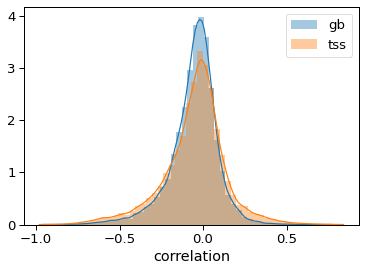

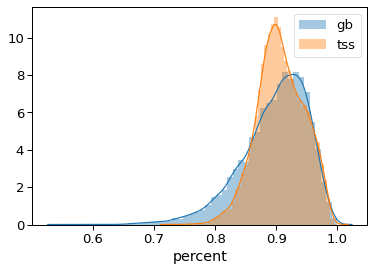

In [159]:
sns.distplot(matchplot.correlation,label="gb")
sns.distplot(matchplot_tss.correlation,label="tss")
plt.legend()
plt.show()

sns.distplot(matchplot.percent,label="gb")
sns.distplot(matchplot_tss.percent,label="tss")
plt.legend()
plt.show()

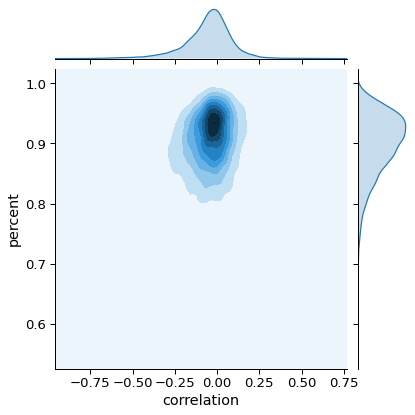

In [129]:
sns.jointplot(data=matchplot,x="correlation",y="percent",kind="kde")
plt.show()

gb acc vs corr:
r: 0.1857999474144341
p: 5.792325046134386e-116


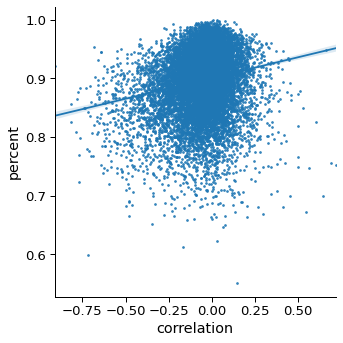

In [148]:
r,p = pearsonr(matchplot["correlation"],matchplot["percent"])
print("gb acc vs corr:")
print("r:",r)
print("p:",p)
sns.lmplot(data=matchplot,x="correlation",y="percent",scatter_kws={"s": 3})
plt.show()

In [150]:
matchplot_tss

,entrez,percent,symbol,C16orf78,MYL3,SMURF1,SNORA11,RNF219,MAP2K5,VASH2,...,TLE6,TMEM88,HTR3B,SNX32,NONO,PITPNM3,SLC34A3,KBTBD8,GLP1R,HMMR
3,10.0,0.928508,NAT2,-0.091856,-0.036649,0.072531,0.190289,0.329742,-0.050734,0.398437,...,0.007823,0.236524,-0.085878,-0.029204,0.552499,0.010873,0.292047,-0.161705,0.370321,-0.177569
4,12.0,0.915280,SERPINA3,-0.059357,-0.066829,-0.206338,-0.025312,-0.045809,-0.129601,-0.230025,...,0.269372,0.188943,0.150863,0.100308,0.156877,0.325987,0.348242,0.183286,0.173949,0.180216
5,13.0,0.885336,AADAC,-0.174383,0.040311,-0.016322,0.198319,0.219237,-0.045650,0.308760,...,-0.055248,0.220055,0.100891,0.156127,0.537224,0.095775,0.376667,-0.103474,0.241989,0.028687
6,15.0,0.937272,AANAT,-0.017403,-0.028478,-0.097059,0.017624,0.104679,-0.008952,0.037175,...,0.159114,0.126181,-0.062271,-0.015145,0.055940,0.018024,0.034436,0.075534,0.102667,-0.079295
7,16.0,0.936379,AARS,0.074737,0.093078,0.170020,-0.117250,-0.160509,-0.082980,-0.018628,...,-0.098839,-0.047767,0.089669,-0.016442,-0.232821,-0.009181,-0.078650,0.152058,-0.136438,0.146374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13394,101927581.0,0.906192,CCDC182,-0.127486,0.007758,-0.188340,0.066498,-0.048098,-0.002537,-0.050415,...,0.008637,-0.068873,0.084641,0.068723,0.166902,0.040551,0.142025,-0.161747,0.053140,-0.009061
13395,101954266.0,0.865698,RNVU1-14,-0.086179,0.077395,-0.060245,0.009283,0.057047,0.067226,-0.100963,...,0.099398,0.223028,0.136975,-0.031035,0.154446,0.197831,0.250834,-0.254768,0.045184,-0.294996
13396,101954269.0,0.903757,RNVU1-17,-0.076808,-0.191018,0.189189,-0.144283,-0.039848,-0.047687,0.072140,...,-0.178892,-0.263414,0.102376,0.198868,0.054359,0.332365,0.004889,0.167177,-0.001449,0.420718
13397,101954271.0,0.978009,RNU6-1,0.055739,0.074633,-0.035746,0.070755,0.087564,0.001607,0.137548,...,0.062596,0.117935,-0.079487,-0.054415,0.091131,-0.080183,-0.024005,-0.061533,0.077356,-0.149581


tss1500 acc vs corr:
r: 0.03696977306505881
p: 0.00010195892225250161


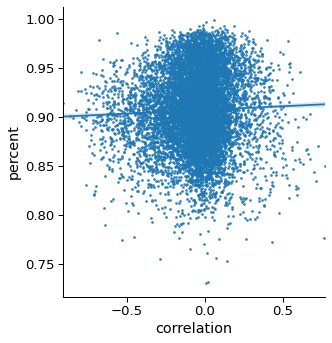

In [152]:
r,p = pearsonr(matchplot_tss["correlation"],matchplot_tss["percent"])
print("tss1500 acc vs corr:")
print("r:",r)
print("p:",p)
sns.lmplot(data=matchplot_tss,x="correlation",y="percent",scatter_kws={"s": 3})
plt.show()

In [193]:
import numpy as np
matchplot['sqrtpercent'] = np.sqrt(matchplot["percent"])
matchplot["positive_correlation"] = matchplot["correlation"]>0
matchplot["r2"] = matchplot["correlation"].apply(lambda  x : x**2)
matchplot["logr2"] = matchplot["r2"].apply(np.log10)
matchplot

,entrez,percent,symbol,correlation,sqrtpercent,logcorr,positive_correlation,r2,logr2
0,1.0,0.752008,A1BG,0.721237,0.867184,-0.070961,True,0.520182,-0.283845
1,2.0,0.958371,A2M,-0.104731,0.978964,NaN,False,0.010969,-1.959847
2,9.0,0.928751,NAT1,-0.166434,0.963717,NaN,False,0.027700,-1.557515
3,10.0,0.888988,NAT2,-0.317764,0.942862,NaN,False,0.100974,-0.995791
4,12.0,0.866997,SERPINA3,-0.432585,0.931127,NaN,False,0.187130,-0.727857
...,...,...,...,...,...,...,...,...,...
16459,101340251.0,0.839406,SNORD124,-0.062298,0.916191,NaN,False,0.003881,-2.411056
16461,101927581.0,0.822852,CCDC182,-0.029174,0.907112,NaN,False,0.000851,-3.070010
16463,101954266.0,0.756796,RNVU1-14,0.028290,0.869940,-0.774181,True,0.000800,-3.096724
16464,101954276.0,0.776597,RNVU1-6,-0.038406,0.881247,NaN,False,0.001475,-2.831213


In [202]:
matchplot_tss['sqrtpercent'] = np.sqrt(matchplot_tss["percent"])
matchplot_tss["positive_correlation"] = matchplot_tss["correlation"]>0
matchplot_tss["r2"] = matchplot_tss["correlation"].apply(lambda  x : x**2)
matchplot_tss["logr2"] = matchplot_tss["r2"].apply(np.log10)
matchplot_tss

,entrez,percent,symbol,correlation,sqrtpercent,positive_correlation,r2,logr2
3,10.0,0.928508,NAT2,-0.773354,0.963591,False,0.598077,-0.223243
4,12.0,0.915280,SERPINA3,-0.623307,0.956703,False,0.388512,-0.410596
5,13.0,0.885336,AADAC,-0.662396,0.940923,False,0.438769,-0.357764
6,15.0,0.937272,AANAT,0.119151,0.968128,True,0.014197,-1.847807
7,16.0,0.936379,AARS,-0.152620,0.967667,False,0.023293,-1.632777
...,...,...,...,...,...,...,...,...
13394,101927581.0,0.906192,CCDC182,-0.029174,0.951941,False,0.000851,-3.070010
13395,101954266.0,0.865698,RNVU1-14,0.028290,0.930429,True,0.000800,-3.096724
13396,101954269.0,0.903757,RNVU1-17,-0.009523,0.950661,False,0.000091,-4.042456
13397,101954271.0,0.978009,RNU6-1,-0.051651,0.988943,False,0.002668,-2.573845


In [241]:
matchplot_tss200['sqrtpercent'] = np.sqrt(matchplot_tss200["percent"])
matchplot_tss200["positive_correlation"] = matchplot_tss200["correlation"]>0
matchplot_tss200["r2"] = matchplot_tss200["correlation"].apply(lambda  x : x**2)
matchplot_tss200["logr2"] = matchplot_tss200["r2"].apply(np.log10)
matchplot_tss200

,entrez,percent,symbol,correlation,sqrtpercent,positive_correlation,r2,logr2
2,10.0,0.956910,NAT2,-0.773354,0.978218,False,0.598077,-0.223243
3,12.0,0.947415,SERPINA3,-0.632782,0.973353,False,0.400414,-0.397491
4,15.0,0.929319,AANAT,0.009414,0.964012,True,0.000089,-4.052416
5,16.0,0.964538,AARS,-0.140581,0.982109,False,0.019763,-1.704144
6,18.0,0.953583,ABAT,-0.081942,0.976516,False,0.006714,-2.172987
...,...,...,...,...,...,...,...,...
9190,100996939.0,0.956017,PYURF,0.148835,0.977761,True,0.022152,-1.654592
9191,101180976.0,0.935000,IFNL4,-0.062870,0.966954,False,0.003953,-2.403109
9192,101340251.0,0.974357,SNORD124,-0.062298,0.987095,False,0.003881,-2.411056
9194,101954266.0,0.894831,RNVU1-14,0.028290,0.945955,True,0.000800,-3.096724


In [171]:
matchplot["logcorr"].dropna().shape,matchplot.shape

((5277,), (14917, 6))

<AxesSubplot:xlabel='percent', ylabel='sqrtpercent'>

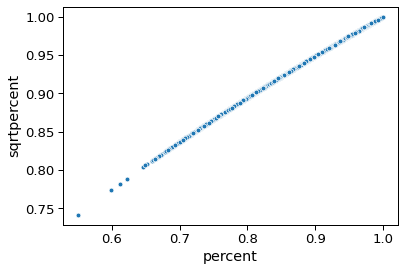

In [198]:
sns.scatterplot(data=matchplot,x="percent",y="sqrtpercent")

gb correlated genes:
r: 0.3073325771002641
p: 5.960229355512417e-210


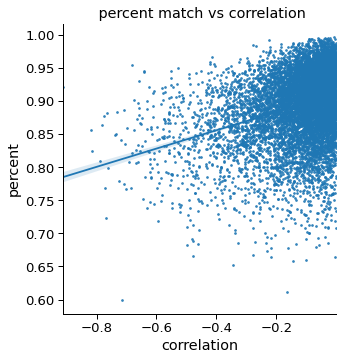

gb anti-correlated genes:
r: -0.1533052958577039
p: 4.069123817102558e-29


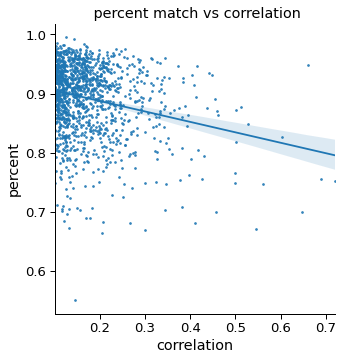

In [209]:
r,p = pearsonr(matchplot[matchplot.correlation<0]["correlation"],matchplot[matchplot.correlation<0]["percent"])
print("gb correlated genes:")
print("r:",r)
print("p:",p)

sns.lmplot(data=matchplot[matchplot.correlation<0],x="correlation",y="percent",scatter_kws={"s": 3})
plt.title(" percent match vs correlation")
plt.show()


r,p = pearsonr(matchplot[matchplot.correlation>0]["correlation"],matchplot[matchplot.correlation>0]["percent"])
print("gb anti-correlated genes:")
print("r:",r)
print("p:",p)


sns.lmplot(data=matchplot[matchplot.correlation>0.1],x="correlation",y="percent",scatter_kws={"s": 3})
plt.title(" percent match vs correlation")
plt.show()


In [ ]:
#try to combine pos/anticorrelation with two regplots on one plot
#or line them up next to one another so they look continuous sort of 


ts1500 correlated genes:
r: 0.06656093918912742
p: 5.260412514674632e-08


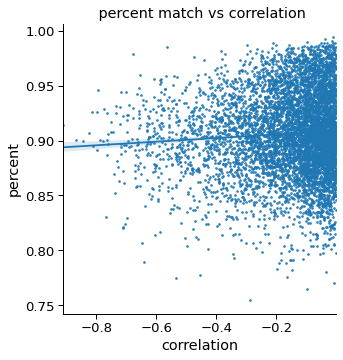

tss1500 anti-correlated genes:
r: -0.028819401472553928
p: 0.056781984152881576


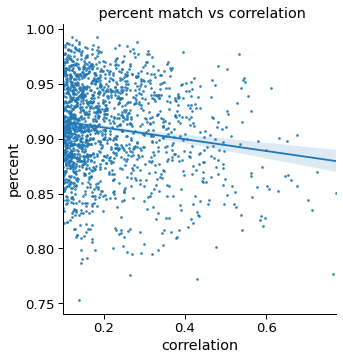

In [211]:
r,p = pearsonr(matchplot_tss[matchplot_tss.correlation<0]["correlation"],matchplot_tss[matchplot_tss.correlation<0]["percent"])
print("ts1500 correlated genes:")
print("r:",r)
print("p:",p)

sns.lmplot(data=matchplot_tss[matchplot_tss.correlation<0],x="correlation",y="percent",scatter_kws={"s": 3})
plt.title(" percent match vs correlation")
plt.show()


r,p = pearsonr(matchplot_tss[matchplot_tss.correlation>0]["correlation"],matchplot_tss[matchplot_tss.correlation>0]["percent"])
print("tss1500 anti-correlated genes:")
print("r:",r)
print("p:",p)


sns.lmplot(data=matchplot_tss[matchplot_tss.correlation>0.1],x="correlation",y="percent",scatter_kws={"s": 3})
plt.title(" percent match vs correlation")
plt.show()


In [ ]:
#compare performance only annotated genes

gb correlated genes:
r: 0.3073325771002641
p: 5.960229355512417e-210
log10r2 correlation:
r: -0.24747151737057602
p: 1.7841360309144508e-134


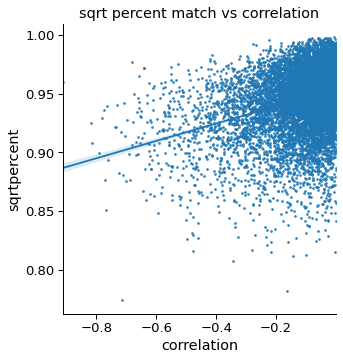

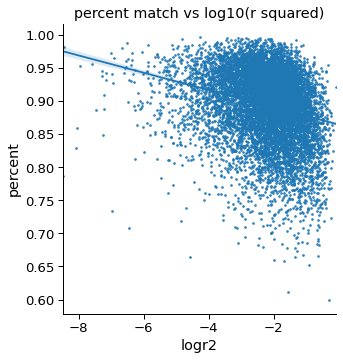

gb anti-correlated genes:
r: -0.1533052958577039
p: 4.069123817102558e-29
log10r2 correlation:
r: -0.0828341426701726
p: 1.6780734516829856e-09


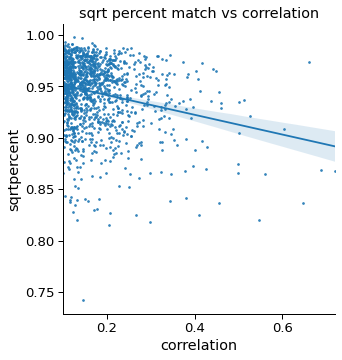

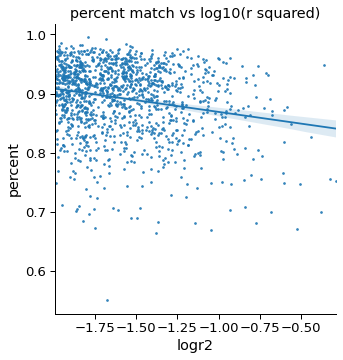

In [201]:
r,p = pearsonr(matchplot[matchplot.correlation<0]["correlation"],matchplot[matchplot.correlation<0]["percent"])
print("gb correlated genes:")
print("r:",r)
print("p:",p)

r,p = pearsonr(matchplot[matchplot.correlation<0]["logr2"],matchplot[matchplot.correlation<0]["percent"])
print("log10r2 correlation:")
print("r:",r)
print("p:",p)

sns.lmplot(data=matchplot[matchplot.correlation<0],x="correlation",y="sqrtpercent",scatter_kws={"s": 3})
plt.title("sqrt percent match vs correlation")
plt.show()
sns.lmplot(data=matchplot[matchplot.correlation<0],x="logr2",y="percent",scatter_kws={"s": 3})
plt.title("percent match vs log10(r squared)")
plt.show()

r,p = pearsonr(matchplot[matchplot.correlation>0]["correlation"],matchplot[matchplot.correlation>0]["percent"])
print("gb anti-correlated genes:")
print("r:",r)
print("p:",p)
r,p = pearsonr(matchplot[matchplot.correlation>0]["logr2"],matchplot[matchplot.correlation>0]["percent"])
print("log10r2 correlation:")
print("r:",r)
print("p:",p)

sns.lmplot(data=matchplot[matchplot.correlation>0.1],x="correlation",y="sqrtpercent",scatter_kws={"s": 3})
plt.title("sqrt percent match vs correlation")
plt.show()
sns.lmplot(data=matchplot[matchplot.correlation>0.1],x="logr2",y="percent",scatter_kws={"s": 3})
plt.title("percent match vs log10(r squared)")
plt.show()

tss1500 correlated genes:
r: 0.06656093918912742
p: 5.260412514674632e-08
log10r2 correlation:
r: -0.027844663050491623
p: 0.02292983076260333


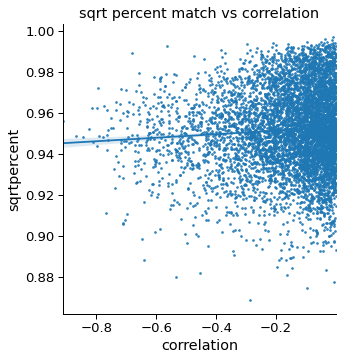

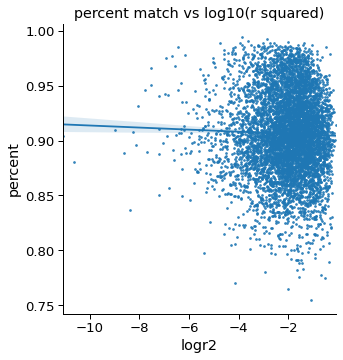

tss1500 anti-correlated genes:
r: -0.028819401472553928
p: 0.056781984152881576
log10r2 correlation:
r: 0.011328139738945526
p: 0.4540576273671646


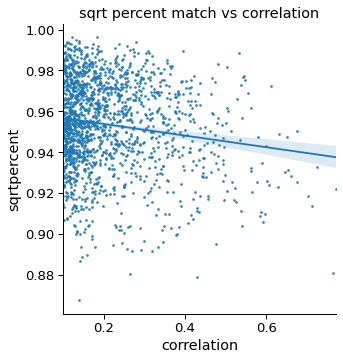

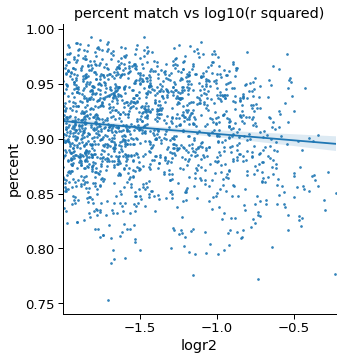

In [204]:
r,p = pearsonr(matchplot_tss[matchplot_tss.correlation<0]["correlation"],matchplot_tss[matchplot_tss.correlation<0]["percent"])
print("tss1500 correlated genes:")
print("r:",r)
print("p:",p)

r,p = pearsonr(matchplot_tss[matchplot_tss.correlation<0]["logr2"],matchplot_tss[matchplot_tss.correlation<0]["percent"])
print("log10r2 correlation:")
print("r:",r)
print("p:",p)

sns.lmplot(data=matchplot_tss[matchplot_tss.correlation<0],x="correlation",y="sqrtpercent",scatter_kws={"s": 3})
plt.title("sqrt percent match vs correlation")
plt.show()
sns.lmplot(data=matchplot_tss[matchplot_tss.correlation<0],x="logr2",y="percent",scatter_kws={"s": 3})
plt.title("percent match vs log10(r squared)")
plt.show()

r,p = pearsonr(matchplot_tss[matchplot_tss.correlation>0]["correlation"],matchplot_tss[matchplot_tss.correlation>0]["percent"])
print("tss1500 anti-correlated genes:")
print("r:",r)
print("p:",p)
r,p = pearsonr(matchplot_tss[matchplot_tss.correlation>0]["logr2"],matchplot_tss[matchplot_tss.correlation>0]["percent"])
print("log10r2 correlation:")
print("r:",r)
print("p:",p)

sns.lmplot(data=matchplot_tss[matchplot_tss.correlation>0.1],x="correlation",y="sqrtpercent",scatter_kws={"s": 3})
plt.title("sqrt percent match vs correlation")
plt.show()
sns.lmplot(data=matchplot_tss[matchplot_tss.correlation>0.1],x="logr2",y="percent",scatter_kws={"s": 3})
plt.title("percent match vs log10(r squared)")
plt.show()

tss1500 correlated genes:
r: -0.17401325659636388
p: 4.859053314577609e-31
log10r2 correlation:
r: 0.16080025755082464
p: 1.0853577150140995e-26


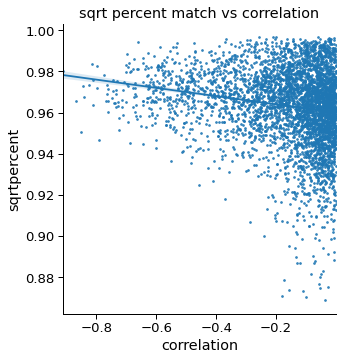

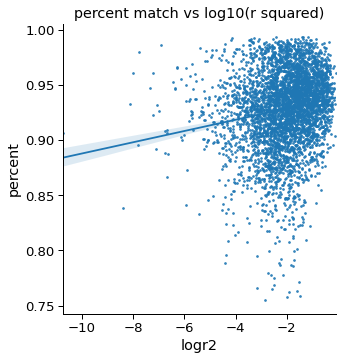

tss1500 anti-correlated genes:
r: 0.11842758161744849
p: 7.14429779394368e-11
log10r2 correlation:
r: 0.08518723307924066
p: 2.8654639310007675e-06


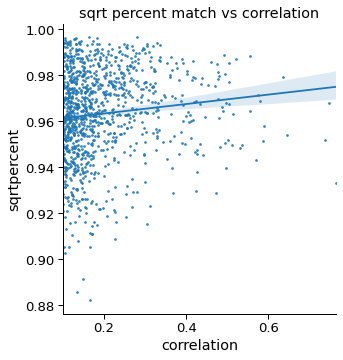

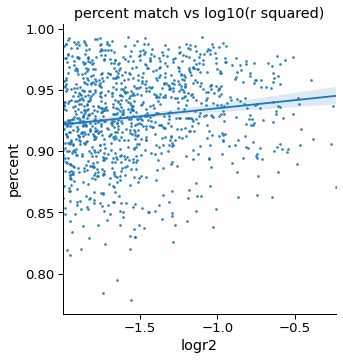

In [242]:
r,p = pearsonr(matchplot_tss200[matchplot_tss200.correlation<0]["correlation"],matchplot_tss200[matchplot_tss200.correlation<0]["percent"])
print("tss1500 correlated genes:")
print("r:",r)
print("p:",p)

r,p = pearsonr(matchplot_tss200[matchplot_tss200.correlation<0]["logr2"],matchplot_tss200[matchplot_tss200.correlation<0]["percent"])
print("log10r2 correlation:")
print("r:",r)
print("p:",p)

sns.lmplot(data=matchplot_tss200[matchplot_tss200.correlation<0],x="correlation",y="sqrtpercent",scatter_kws={"s": 3})
plt.title("sqrt percent match vs correlation")
plt.show()
sns.lmplot(data=matchplot_tss200[matchplot_tss200.correlation<0],x="logr2",y="percent",scatter_kws={"s": 3})
plt.title("percent match vs log10(r squared)")
plt.show()

r,p = pearsonr(matchplot_tss200[matchplot_tss200.correlation>0]["correlation"],matchplot_tss200[matchplot_tss200.correlation>0]["percent"])
print("tss1500 anti-correlated genes:")
print("r:",r)
print("p:",p)
r,p = pearsonr(matchplot_tss200[matchplot_tss200.correlation>0]["logr2"],matchplot_tss200[matchplot_tss200.correlation>0]["percent"])
print("log10r2 correlation:")
print("r:",r)
print("p:",p)

sns.lmplot(data=matchplot_tss200[matchplot_tss200.correlation>0.1],x="correlation",y="sqrtpercent",scatter_kws={"s": 3})
plt.title("sqrt percent match vs correlation")
plt.show()
sns.lmplot(data=matchplot_tss200[matchplot_tss200.correlation>0.1],x="logr2",y="percent",scatter_kws={"s": 3})
plt.title("percent match vs log10(r squared)")
plt.show()

tss1500 correlated genes:
r: -0.1745748164446343
p: 3.117250378071925e-31


<Figure size 360x360 with 0 Axes>

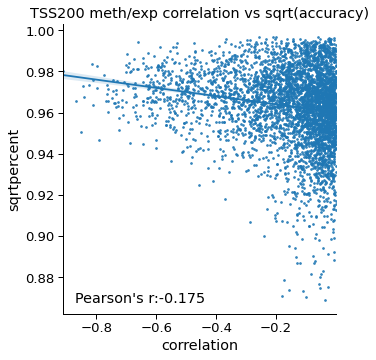

tss1500 anti-correlated genes:
r: 0.11809601262072249
p: 8.073773265938913e-11


<Figure size 360x360 with 0 Axes>

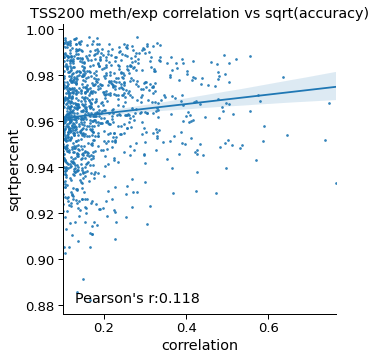

In [266]:
r,p = pearsonr(matchplot_tss200[matchplot_tss200.correlation<0]["correlation"],matchplot_tss200[matchplot_tss200.correlation<0]["sqrtpercent"])
print("tss1500 correlated genes:")
print("r:",r)
print("p:",p)

#r,p = pearsonr(matchplot_tss200[matchplot_tss200.correlation<0]["correlation"],matchplot_tss200[matchplot_tss200.correlation<0]["percent"])
#print("tss1500 correlated genes:")
#print("r:",r)
#print("p:",p)

plt.figure(figsize=(5,5))
sns.lmplot(data=matchplot_tss200[matchplot_tss200.correlation<0],x="correlation",y="sqrtpercent",scatter_kws={"s": 3})
plt.title("TSS200 meth/exp correlation vs sqrt(accuracy)")
plt.annotate("Pearson's r:%s"%(np.round(r,3)),xy=(0.2,0.16),xycoords="figure fraction")
plt.show()

r,p = pearsonr(matchplot_tss200[matchplot_tss200.correlation>0]["correlation"],matchplot_tss200[matchplot_tss200.correlation>0]["sqrtpercent"])
print("tss1500 anti-correlated genes:")
print("r:",r)
print("p:",p)

#r,p = pearsonr(matchplot_tss200[matchplot_tss200.correlation>0]["correlation"],matchplot_tss200[matchplot_tss200.correlation>0]["percent"])
#print("tss1500 anti-correlated genes:")
#print("r:",r)
#print("p:",p)
plt.figure(figsize=(5,5))
sns.lmplot(data=matchplot_tss200[matchplot_tss200.correlation>0.1],x="correlation",y="sqrtpercent",scatter_kws={"s": 3})
plt.title("TSS200 meth/exp correlation vs sqrt(accuracy)")
plt.annotate("Pearson's r:%s"%(np.round(r,3)),xy=(0.2,0.16),xycoords="figure fraction")
plt.show()

/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/TSS200_correlation_paired_corr_vs_accuracy.png


<Figure size 576x432 with 0 Axes>

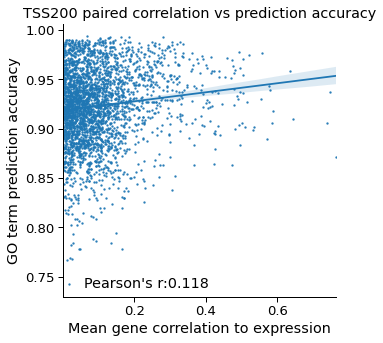

/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/TSS200_anticorrelation_paired_corr_vs_accuracy.png


<Figure size 576x432 with 0 Axes>

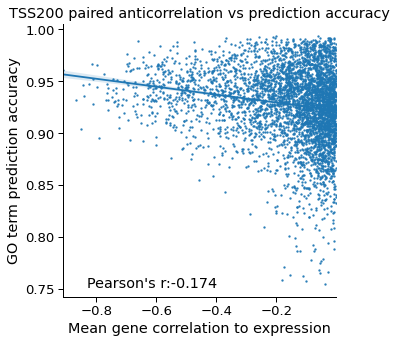

/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/TSS1500_correlation_paired_corr_vs_accuracy.png


<Figure size 576x432 with 0 Axes>

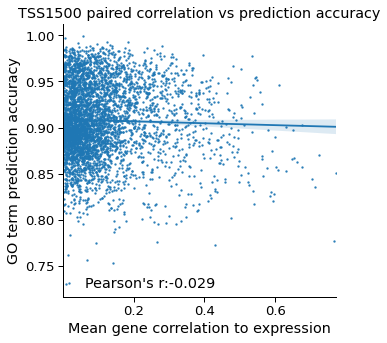

/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/TSS1500_anticorrelation_paired_corr_vs_accuracy.png


<Figure size 576x432 with 0 Axes>

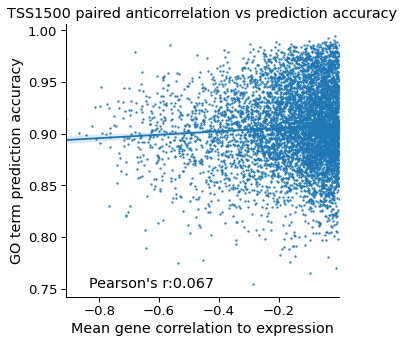

/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/Gene body_correlation_paired_corr_vs_accuracy.png


<Figure size 576x432 with 0 Axes>

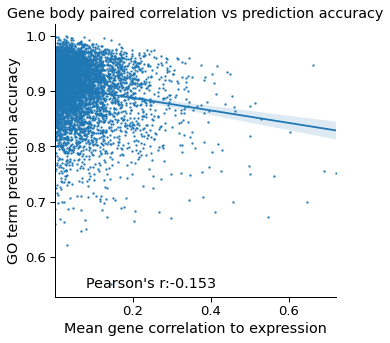

/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/Gene body_anticorrelation_paired_corr_vs_accuracy.png


<Figure size 576x432 with 0 Axes>

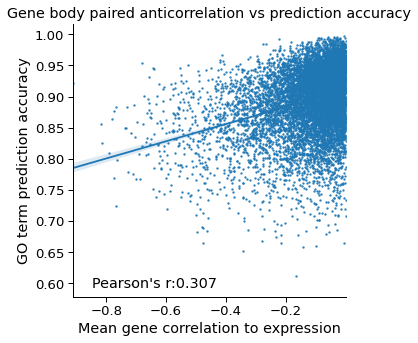

In [309]:
def makeplot(df,title):
    r,p = pearsonr(df["correlation"],df["percent"])
    plt.figure(figsize=(8,6))
    sns.lmplot(data=df,x="correlation",y="percent",scatter_kws={"s": 2})
    plt.title("%s paired %s vs prediction accuracy"%(title.split("_")[0],title.split("_")[1]))
    #plt.title(r'$\alpha > \beta$')
    plt.annotate("Pearson's r:%s"%(np.round(r,3)),xy=(0.22,0.16),xycoords="figure fraction")
    #plt.ylabel(r'$\sqrt{(accuracy)}$')
    plt.ylabel("GO term prediction accuracy")
    plt.xlabel("Mean gene correlation to expression")
    fname = "/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/%s_paired_corr_vs_accuracy"%(title)
    print(fname+".png")
    plt.tight_layout()
    plt.savefig(fname+".png")
    plt.savefig(fname+".svg")
    plt.show()

def makeplots(df,title): #title is tss200 or something
    c = df[df.correlation>0]
    c = makeplot(c,title=title+"_correlation")
    a = df[df.correlation<0]
    a = makeplot(a,title=title+"_anticorrelation")

makeplots(matchplot_tss200,title="TSS200")
makeplots(matchplot_tss,title="TSS1500")
makeplots(matchplot,title="Gene body")

In [290]:
matchplot_tss200

,entrez,percent,symbol,correlation,sqrtpercent,positive_correlation,r2,logr2
2,10.0,0.956910,NAT2,-0.773354,0.978218,False,0.598077,-0.223243
3,12.0,0.947415,SERPINA3,-0.632782,0.973353,False,0.400414,-0.397491
4,15.0,0.929319,AANAT,0.009414,0.964012,True,0.000089,-4.052416
5,16.0,0.964538,AARS,-0.140581,0.982109,False,0.019763,-1.704144
6,18.0,0.953583,ABAT,-0.081942,0.976516,False,0.006714,-2.172987
...,...,...,...,...,...,...,...,...
9190,100996939.0,0.956017,PYURF,0.148835,0.977761,True,0.022152,-1.654592
9191,101180976.0,0.935000,IFNL4,-0.062870,0.966954,False,0.003953,-2.403109
9192,101340251.0,0.974357,SNORD124,-0.062298,0.987095,False,0.003881,-2.411056
9194,101954266.0,0.894831,RNVU1-14,0.028290,0.945955,True,0.000800,-3.096724


In [215]:
matchplot.to_csv("/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/paired_gdc_corr_to_auc_gb_plot.csv")

In [216]:
matchplot_tss.to_csv("/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/paired_gdc_corr_to_auc_tss1500_plot.csv")

In [207]:
m= "/data/ncbi.bak/geo/GPL13534/meta/meth_tools/mana/mana_prediction_summary.h5"
m= pd.read_hdf(m,key="data")
m

,TermID,weighted_logr_gb,weighted_logr_tss1500,weighted_logr_tss200,weighted_logr_tss5050,weighted_logr_ex,logr_gb,logr_tss1500,logr_tss200,logr_tss5050,...,logr_tss1500_median,logr_tss200_median,logr_tss5050_median,logr_exp_median,logr_gb_median,GO_ID,GO_term,Category,count,downsampled_gb
0,1,0.656927,0.815681,NaN,NaN,0.931093,0.630428,0.822417,NaN,NaN,...,0.825785,NaN,NaN,0.936978,0.792833,GO:0000001,mitochondrion inheritance,Process,60.0,0.763250
1,2,0.841936,0.843258,0.855658,NaN,0.912530,0.802440,0.835093,0.855995,NaN,...,0.857816,0.840753,NaN,0.906974,0.868835,GO:0000002,mitochondrial genome maintenance,Process,156.0,0.733546
2,12,0.921832,0.949717,0.967986,0.974029,0.954948,0.923897,0.947536,0.968229,0.973774,...,0.937816,0.972927,0.975270,0.957187,0.892625,GO:0000012,single strand break repair,Process,57.0,0.947502
3,13,0.878054,0.807321,NaN,NaN,0.983321,0.762682,0.774653,NaN,NaN,...,0.805048,NaN,NaN,0.959703,0.955604,NaN,NaN,NaN,NaN,0.865352
4,14,0.747829,NaN,NaN,0.818979,0.842560,0.767980,NaN,NaN,0.826000,...,NaN,NaN,0.857446,0.846233,0.751076,GO:0000014,single-stranded DNA endodeoxyribonuclease acti...,Function,78.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15058,107080638,0.812414,NaN,NaN,NaN,NaN,0.835945,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.788801,NaN,NaN,NaN,NaN,NaN
15059,109504726,0.766821,NaN,NaN,NaN,NaN,0.755377,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.844737,NaN,NaN,NaN,NaN,NaN
15060,110117498,0.891851,0.919365,0.865474,0.736994,NaN,0.897573,0.955604,0.852528,0.737805,...,0.968022,0.860563,0.755012,NaN,0.953129,NaN,NaN,NaN,NaN,0.950653
15061,112441434,0.919920,0.866081,0.865107,0.954988,NaN,0.889541,0.833712,0.846315,0.934086,...,0.847755,0.871378,0.935648,NaN,0.875132,NaN,NaN,NaN,NaN,0.667424


In [ ]:
#replot as log axis and sqrt y axis 
#double check geoparse possibility 


r: 0.2886831610339295
p: 7.866947084634191e-85


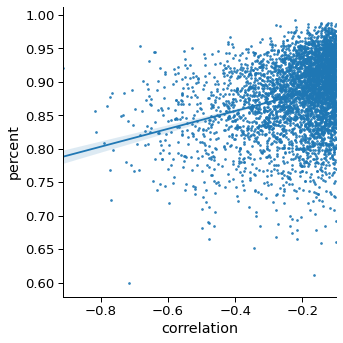

r: -0.22905739427672947
p: 3.2824642149983605e-17


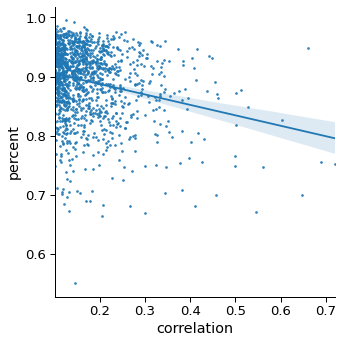

In [136]:
r,p = pearsonr(matchplot[matchplot.correlation<-0.1]["correlation"],matchplot[matchplot.correlation<-0.1]["percent"])
print("r:",r)
print("p:",p)
sns.lmplot(data=matchplot[matchplot.correlation<-0.1],x="correlation",y="percent",scatter_kws={"s": 3})
plt.show()

r,p = pearsonr(matchplot[matchplot.correlation>0.1]["correlation"],matchplot[matchplot.correlation>0.1]["percent"])
print("r:",r)
print("p:",p)
sns.lmplot(data=matchplot[matchplot.correlation>0.1],x="correlation",y="percent",scatter_kws={"s": 3})
plt.show()


In [126]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr